In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results
### Calculate the date 1 year ago from the last data point in the database
### Perform a query to retrieve the data and precipitation scores
### Save the query results as a Pandas DataFrame and set the index to the date column
### Sort the dataframe by date
### Use Pandas Plotting with Matplotlib to plot the data

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day

query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [12]:
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

In [13]:
date = []
prcp = []

for result in results:
    date.append(result[0])
    prcp.append(result[1])

df = pd.DataFrame(index = date, data= prcp, columns= ['precipitation'])

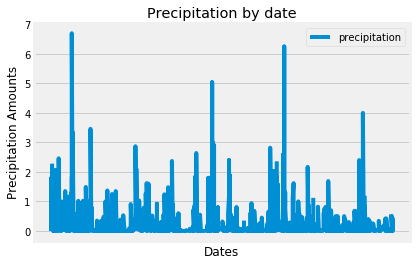

In [15]:
#this works!!!
y = df['precipitation']
x = df.index.values
ax = plt.axes
#won't add grid lines??????????
plt.plot(x,y)
plt.title("Precipitation by date")
plt.xticks([])
plt.xlabel("Dates")
plt.ylabel("Precipitation Amounts")
plt.legend(loc='upper right')
plt.grid(True)
plt.grid(b=True, which='major', axis='y')
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
numofstations = session.query(Station).count()
print("{} stations in the data".format(numofstations))

9 stations in the data


In [18]:
session.query(Measurement.station).count()

19550

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station).all()

station_count = pd.Series(active_stations).value_counts().to_dict()
station_count

{('USC00519281'): 2772,
 ('USC00519397'): 2724,
 ('USC00513117'): 2709,
 ('USC00519523'): 2669,
 ('USC00516128'): 2612,
 ('USC00514830'): 2202,
 ('USC00511918'): 1979,
 ('USC00517948'): 1372,
 ('USC00518838'): 511}

In [20]:
most_station_id = next(iter(station_count.keys()))
most_station_id

('USC00519281')

In [21]:
station_count_2= session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by((func.count(Measurement.station).desc())).all()
most_station_id = station_count_2[0][0]
most_station_id

'USC00519281'

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station = 'USC00519281'

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.station == station ).all()

[(54.0, 71.66378066378067, 85.0)]

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.tobs).\
                filter(Measurement.station == station).count()

2772

In [25]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results= session.query(Measurement.tobs).\
                filter(Measurement.station == station, Measurement.date > query_date).all()

In [58]:
temps = []

for result in temp_results:
    temps.append(result[0])

df_temp = pd.DataFrame(temps, columns= ['temperature'])

In [59]:
df_temp

,temperature
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0
5,78.0
6,77.0
7,78.0
8,80.0
9,80.0


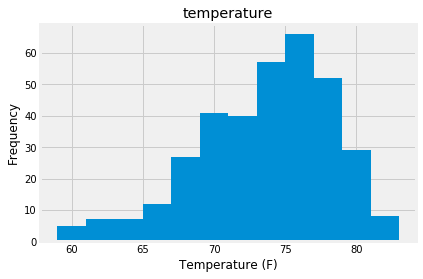

In [34]:
df_temp.hist(bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

![precipitation](Images/station-histogram.png)

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-05-14', '2017-05-22'))

[(68.0, 74.66, 80.0)]


In [66]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temp_results = (calc_temps('2016-05-14', '2016-05-22'))
calc_temp_results

[(70.0, 75.71428571428571, 79.0)]

In [85]:
avg_temp = []
min_temp = []
max_temp= []

for result in calc_temp_results:
    min_temp.append(result[0])
    avg_temp.append(result[1])
    max_temp.append(result[2])

length = len(avg_temp)
variance = calc_temp_results[0][2] - calc_temp_results[0][0]

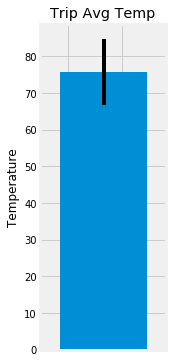

In [107]:
plt.axes()
plt.bar(length, avg_temp, yerr=variance)
fig= plt.gcf()
fig.set_size_inches(2,6)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.xlim(-.25,.90)
plt.tick_params(axis='x', which = 'both', labelbottom=False)

In [99]:
#another way I did it
#max_temp = calc_temp_results[0][2]
#min_temp = calc_temp_results[0][0]
#avg_temp = calc_temp_results[0][1]

#plt.bar(data_2, avg_temp, color='blue', yerr=variance)

In [123]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-05-14'
end_date = '2016-05-22'


trip_weather= session.query(Measurement.station, Measurement.date, Measurement.prcp, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

In [124]:
trip_weather

[('USC00516128',
  '2016-05-20',
  0.71,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  '2016-05-22',
  0.04,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  '2016-05-22',
  0.04,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117',
  '2016-05-22',
  0.0,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519397',
  '2016-05-22',
  0.0,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  '2016-05-22',
  0.0,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948',
  '2016-05-20',
  None,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
